# Preprocess data

## import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from pathlib import Path

## Load the original data of this study

In [3]:

RECORD_ID = "17285665"           # <- Zenodo record ID
API_URL   = f"https://zenodo.org/api/records/{RECORD_ID}"
OUT_DIR   = Path("./data")
OUT_DIR.mkdir(parents=True, exist_ok=True)

def sizeof_fmt(num, suffix="B"):
    for unit in ["","K","M","G","T","P","E","Z"]:
        if abs(num) < 1024.0:
            return f"{num:3.1f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Y{suffix}"

def stream_download(url: str, dest: Path, chunk_size: int = 1024 * 1024):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total = int(r.headers.get("Content-Length", 0))
        downloaded = 0
        with open(dest, "wb") as f:
            for chunk in r.iter_content(chunk_size=chunk_size):
                if not chunk:
                    continue
                f.write(chunk)
                downloaded += len(chunk)
                if total > 0:
                    done = int(50 * downloaded / total)
                    bar = "=" * done + " " * (50 - done)
                    pct = 100 * downloaded / total
                    sys.stdout.write(f"\r[{bar}] {pct:5.1f}%  {sizeof_fmt(downloaded)} / {sizeof_fmt(total)}")
                    sys.stdout.flush()
        if total > 0:
            sys.stdout.write("\n")

def download_zenodo():
    print(f"Querying Zenodo API: {API_URL}")
    resp = requests.get(API_URL, timeout=30)
    resp.raise_for_status()
    rec = resp.json()

    files = rec.get("files", [])
    if not files:
        # Some records store files under 'links' or in 'hits', but for a single record they should be in 'files'
        print("⚠️ No files listed in the API response. Check the record permissions or structure.")
        print("Raw keys in response:", list(rec.keys()))
        return

    print(f"Found {len(files)} files. Starting download to {OUT_DIR.resolve()}")

    for f in files:
        # API fields typically include: key (filename), size, links: { self, download }
        name = f.get("key") or f.get("filename") or "unknown.bin"
        size = f.get("size", 0)
        links = f.get("links", {})
        # Prefer the direct download link if available; fallback to 'self'
        url = links.get("download") or links.get("self")

        if not url:
            print(f"  • Skipping {name}: no download URL in file entry")
            continue

        dest = OUT_DIR / name
        # Avoid re-downloading if file exists and size matches
        if dest.exists() and (size == 0 or dest.stat().st_size == size):
            print(f"  • Skipping (already exists) {name}  [{sizeof_fmt(dest.stat().st_size)}]")
            continue

        print(f"⬇️  Downloading {name}  [{sizeof_fmt(size)}] …")
        try:
            stream_download(url, dest)
            print(f"✅ Saved: {dest}")
        except Exception as e:
            print(f"❌ Failed: {name} -> {e}")

    print("\n🎯 Done.")



In [4]:

download_zenodo()


Querying Zenodo API: https://zenodo.org/api/records/17285665
Found 2 files. Starting download to /home/jmsaborit/UMIB/First-episode_Psychosis_Clasification/src/2_preprocess_data/data
  • Skipping (already exists) dataset_description.json  [935.0B]
  • Skipping (already exists) df_features.tsv  [606.9MB]

🎯 Done.


## Load the table with features

In [ ]:
features_df = pd.read_csv('src/2_preprocess_data/data/df_features.tsv', sep='\t', low_memory=False)


The ID column is set as the index.

In [52]:

features_df.set_index("ID", inplace=True)
display(features_df.head())

,Label,label1001_diagnostics_Configuration_EnabledImageTypes,label1001_diagnostics_Configuration_Settings,label1001_diagnostics_Image-original_Dimensionality,label1001_diagnostics_Image-original_Hash,label1001_diagnostics_Image-original_Maximum,label1001_diagnostics_Image-original_Mean,label1001_diagnostics_Image-original_Minimum,label1001_diagnostics_Image-original_Size,label1001_diagnostics_Image-original_Spacing,...,label8_wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,label8_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,label8_wavelet-LLL_glszm_SizeZoneNonUniformity,label8_wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,label8_wavelet-LLL_glszm_SmallAreaEmphasis,label8_wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,label8_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,label8_wavelet-LLL_glszm_ZoneEntropy,label8_wavelet-LLL_glszm_ZonePercentage,label8_wavelet-LLL_glszm_ZoneVariance
ID,,,,,,,,,,,,,,,,,,,,,
000002_000002,1.0,"{'Original': {}, 'LoG': {'sigma': [1.0, 3.0, 5...","{'minimumROIDimensions': 2, 'minimumROISize': ...",3D,849547dc176346e81af9662f3f08d673e9d0a77f,133.0,6.949799,0.0,"(256, 256, 256)","(0.9999999403953552, 1.0, 0.9999999403953552)",...,2.732780e+09,1.0,1.0,1.0,3.659277e-10,3.659277e-10,3.659277e-10,-3.203427e-16,0.000019,0.0
000153_000191,0.0,"{'Original': {}, 'LoG': {'sigma': [1.0, 3.0, 5...","{'minimumROIDimensions': 2, 'minimumROISize': ...",3D,df9cbc5890168ba1746be1b63bf2c5cb4b73c4e7,196.0,7.360649,0.0,"(256, 256, 256)","(0.9999999403953552, 0.9999999403953552, 0.999...",...,2.538547e+09,1.0,1.0,1.0,3.939261e-10,3.939261e-10,3.939261e-10,-3.203427e-16,0.000020,0.0
000186_000227,0.0,"{'Original': {}, 'LoG': {'sigma': [1.0, 3.0, 5...","{'minimumROIDimensions': 2, 'minimumROISize': ...",3D,76548dbb67e5e00c6d4709a919cb793d780a0d38,182.0,8.354849,0.0,"(256, 256, 256)","(0.9999999403953552, 0.9999999403953552, 0.999...",...,3.037994e+09,1.0,1.0,1.0,3.291646e-10,3.291646e-10,3.291646e-10,-3.203427e-16,0.000018,0.0
000035_000046,1.0,"{'Original': {}, 'LoG': {'sigma': [1.0, 3.0, 5...","{'minimumROIDimensions': 2, 'minimumROISize': ...",3D,4817118c40f29f1c9fa6c0323e221b3c31c1aa1c,176.0,8.187306,0.0,"(256, 256, 256)","(1.0000001192092896, 1.0000001192092896, 1.000...",...,2.744293e+09,1.0,1.0,1.0,3.643926e-10,3.643926e-10,3.643926e-10,-3.203427e-16,0.000019,0.0
000061_000078,1.0,"{'Original': {}, 'LoG': {'sigma': [1.0, 3.0, 5...","{'minimumROIDimensions': 2, 'minimumROISize': ...",3D,bf4bf1a40b5b67d098d9e1ef7be8407c5b076178,158.0,7.187359,0.0,"(256, 256, 256)","(1.0000001192092896, 1.0000001192092896, 1.0)",...,3.376888e+09,1.0,1.0,1.0,2.961306e-10,2.961306e-10,2.961306e-10,-3.203427e-16,0.000017,0.0


We start with 121214 columns with information about the radiomic output in the folder data.

In [53]:
# Show the shape of the table
features_df.shape


(304, 121213)

In [54]:
# Guardar el número inicial de columnas
total_cols = features_df.shape[1]

# Eliminar todas las columnas que contengan 'diagnostics' en el nombre
cols_to_remove = [col for col in features_df.columns if "diagnostics" in col.lower()]
features_df = features_df.loc[:, ~features_df.columns.str.contains("diagnostics", case=False)]

# Resumen
new_total = features_df.shape[1]
removed = total_cols - new_total
perc_removed = (removed / total_cols) * 100
print(f"Se excluyen {removed} variables de {total_cols} columnas ({perc_removed:.1f}%) -> nuevo tamaño de {new_total}")

# display(features_df.head())


Se excluyen 2442 variables de 121213 columnas (2.0%) -> nuevo tamaño de 118771


In [55]:
# Guardar el número inicial de columnas
total_cols = features_df.shape[1]

# 1) Eliminar columnas con 'label62'
cols_to_remove = [col for col in features_df.columns if "label62" in col]
print(f"Eliminando {len(cols_to_remove)} columnas que contienen 'label62'")
features_df.drop(columns=cols_to_remove, inplace=True)

# 2) Eliminar columnas con 'label30'
cols_to_remove = [col for col in features_df.columns if "label30" in col]
print(f"Eliminando {len(cols_to_remove)} columnas que contienen 'label30'")
features_df.drop(columns=cols_to_remove, inplace=True)

# Resumen final
new_total = features_df.shape[1]
removed = total_cols - new_total
perc_removed = (removed / total_cols) * 100
print(f"Se excluyen {removed} variables de {total_cols} columnas ({perc_removed:.1f}%) -> nuevo tamaño de {new_total}")


Eliminando 1070 columnas que contienen 'label62'
Eliminando 1070 columnas que contienen 'label30'
Se excluyen 2140 variables de 118771 columnas (1.8%) -> nuevo tamaño de 116631


In [56]:
# Guardar el número inicial de columnas
total_cols = features_df.shape[1]

# Columnas con más del 50% de NaNs
cols_to_drop = features_df.columns[features_df.isna().sum() > features_df.shape[0] / 2]

# Extraer solo la parte label(d+)
labels = cols_to_drop.str.extract(r"(label\d+)")[0].dropna().unique()

# Eliminar columnas
features_df.drop(columns=cols_to_drop, inplace=True)

# Resumen
new_total = features_df.shape[1]
removed = total_cols - new_total
perc_removed = (removed / total_cols) * 100
print(f"Se excluyen {removed} variables de {total_cols} columnas ({perc_removed:.1f}%) -> nuevo tamaño de {new_total}")
print(f"Etiquetas afectadas: {list(labels)}")


Se excluyen 2140 variables de 116631 columnas (1.8%) -> nuevo tamaño de 114491
Etiquetas afectadas: ['label72', 'label80']


In [57]:
features_df.update(features_df.transform(lambda x: x.fillna(x.mean())))

In [ ]:


def entropy(series: pd.Series) -> float:
    """Calcula entropía de Shannon en bits para una serie."""
    counts = series.value_counts(normalize=True, dropna=True)
    return -np.sum(counts * np.log2(counts))

def redundancy_and_entropy(df: pd.DataFrame):
    results = []
    for col in df.columns:
        counts = df[col].value_counts(normalize=True, dropna=True)
        if counts.empty:
            max_freq = np.nan
            ent = np.nan
        else:
            max_freq = counts.iloc[0]   # frecuencia del valor más repetido
            ent = entropy(df[col])
        results.append({
            "Variable": col,
            "MaxFreq(%)": round(max_freq * 100, 2) if pd.notna(max_freq) else np.nan,
            "Entropy(bits)": round(ent, 4) if pd.notna(ent) else np.nan
        })
    return pd.DataFrame(results).sort_values("MaxFreq(%)", ascending=False)

# === Uso con tu dataframe ===
summary = redundancy_and_entropy(features_df)

# Mostrar top 20 con más repetición
print(summary.head(20))

                                                Variable  MaxFreq(%)  \
67709               label2022_original_glcm_JointAverage       100.0   
67708            label2022_original_glcm_InverseVariance       100.0   
67707                       label2022_original_glcm_Imc2       100.0   
68409        label2022_wavelet-LLL_firstorder_Uniformity       100.0   
67713         label2022_original_glcm_MaximumProbability       100.0   
67738   label2022_original_glrlm_LowGrayLevelRunEmphasis       100.0   
67732  label2022_original_glrlm_GrayLevelNonUniformit...       100.0   
67733         label2022_original_glrlm_GrayLevelVariance       100.0   
67734  label2022_original_glrlm_HighGrayLevelRunEmphasis       100.0   
67722          label2022_original_gldm_GrayLevelVariance       100.0   
67723      label2022_original_gldm_HighGrayLevelEmphasis       100.0   
68396           label2022_wavelet-LLL_firstorder_Entropy       100.0   
68418       label2022_wavelet-LLL_glcm_DifferenceEntropy       1

In [59]:

# save the summary of entropy and redundancy
summary.to_csv("src/2_preprocess_data/data/redundancy_entropy_summary.tsv", sep='\t', index=False)

In [ ]:


# === CONFIGURACIÓN ===
xcol = "MaxFreq(%)"      # % del valor más repetido
ycol = "Entropy(bits)"   # entropía en bits
x_cut = 30               # umbral repetición (ajústalo)
y_cut = 6.0              # umbral entropía   (ajústalo)
gridsize = 70            # resolución del hexbin (40-120)

# Limpieza básica
data = summary[[xcol, ycol]].dropna().astype(float)
x = data[xcol].to_numpy()
y = data[ycol].to_numpy()


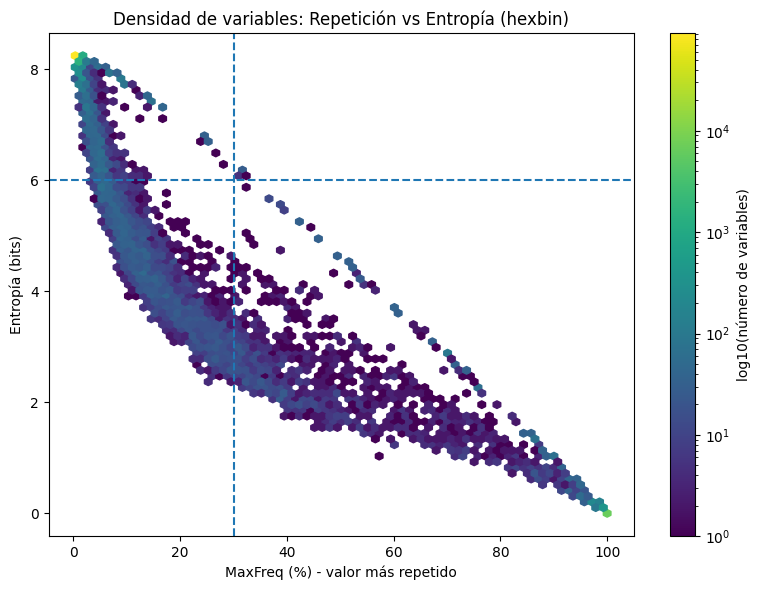

In [61]:

# === 1) HEXBIN (denso y rápido) ===
plt.figure(figsize=(8, 6))
hb = plt.hexbin(x, y, gridsize=gridsize, bins='log')  # densidad en log
cb = plt.colorbar(hb)
cb.set_label("log10(número de variables)")

# Líneas guía
plt.axvline(x_cut, linestyle="--")
plt.axhline(y_cut, linestyle="--")

plt.xlabel("MaxFreq (%) - valor más repetido")
plt.ylabel("Entropía (bits)")
plt.title("Densidad de variables: Repetición vs Entropía (hexbin)")
plt.tight_layout()
plt.show()


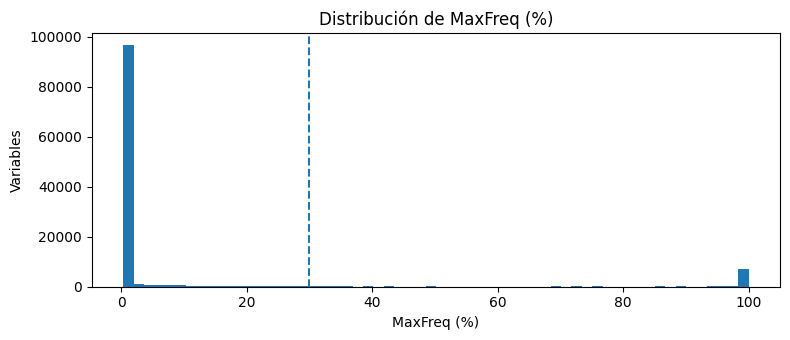

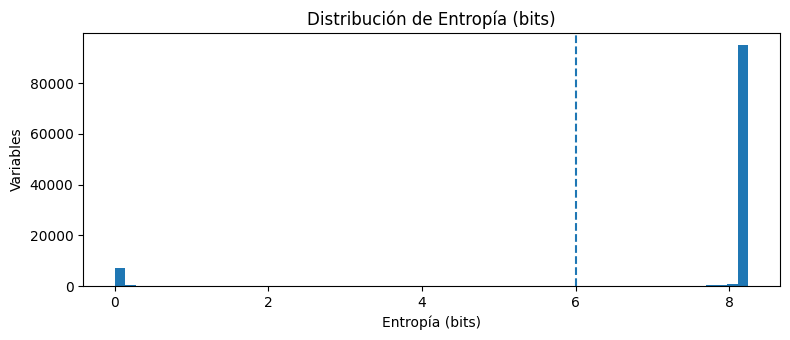

In [62]:

# === 2) HISTOGRAMAS 1D (rápidos) ===
# Distribución de MaxFreq(%)
plt.figure(figsize=(8, 3.5))
plt.hist(x, bins=60)
plt.axvline(x_cut, linestyle="--")
plt.xlabel("MaxFreq (%)")
plt.ylabel("Variables")
plt.title("Distribución de MaxFreq (%)")
plt.tight_layout()
plt.show()

# Distribución de Entropía
plt.figure(figsize=(8, 3.5))
plt.hist(y, bins=60)
plt.axhline(0, linewidth=0.5)  # base
plt.axvline(y_cut, linestyle="--")
plt.xlabel("Entropía (bits)")
plt.ylabel("Variables")
plt.title("Distribución de Entropía (bits)")
plt.tight_layout()
plt.show()


Candidatas a excluir (MaxFreq>30% y Entropía<6.0): 10736/114491 (9.4%)


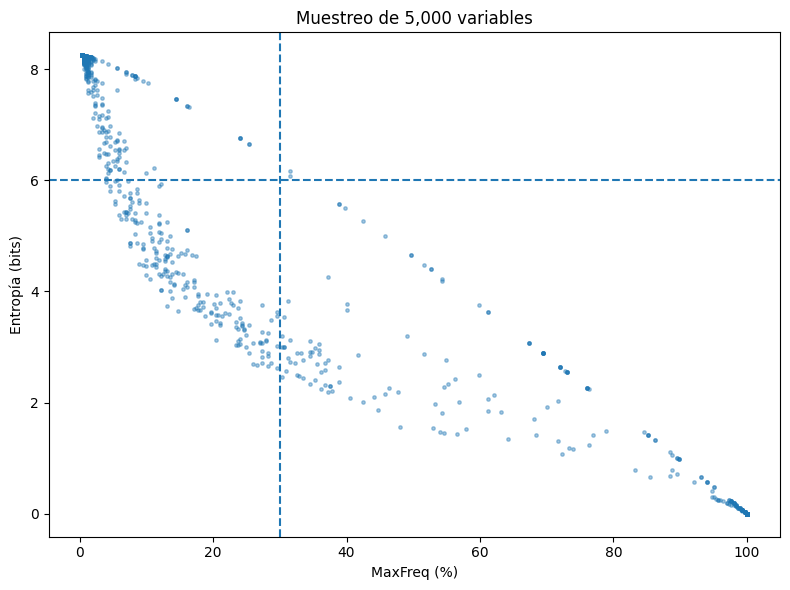

In [63]:

# === 3) MÉTRICAS DE FILTRO (conteos sin graficar) ===
mask_candidates = (x > x_cut) & (y < y_cut)
n_total = len(x)
n_cand  = int(mask_candidates.sum())
print(f"Candidatas a excluir (MaxFreq>{x_cut}% y Entropía<{y_cut}): {n_cand}/{n_total} "
      f"({n_cand/n_total:.1%})")

# === 4) (Opcional) Muestra dispersión por muestreo para ver puntos reales ===
# útil si quieres una “sensación” de los puntos sin coste grande
sample_n = 5000  # baja/ajusta según equipo
if n_total > sample_n:
    idx = np.random.choice(n_total, sample_n, replace=False)
else:
    idx = np.arange(n_total)

plt.figure(figsize=(8, 6))
plt.scatter(x[idx], y[idx], s=6, alpha=0.4)
plt.axvline(x_cut, linestyle="--")
plt.axhline(y_cut, linestyle="--")
plt.xlabel("MaxFreq (%)")
plt.ylabel("Entropía (bits)")
plt.title(f"Muestreo de {len(idx):,} variables")
plt.tight_layout()
plt.show()

In [64]:
# Umbrales
x_cut = 40.0   # MaxFreq %
y_cut = 6.0    # Entropía (bits)

# Número inicial de columnas
total_cols = features_df.shape[1]

# Filtrar variables candidatas a excluir (sin excluir 'Label')
mask_excluir = (
    (summary["MaxFreq(%)"] > x_cut)
    & (summary["Entropy(bits)"] < y_cut)
    & (~summary["Variable"].eq("Label"))
)

# Lista de columnas a eliminar
cols_excluir = summary.loc[mask_excluir, "Variable"].tolist()

# Crear un nuevo dataframe sin esas variables
features_df_filtrado = features_df.drop(columns=cols_excluir, errors="ignore")

# Resumen
new_total = features_df_filtrado.shape[1]
removed = total_cols - new_total
perc_removed = (removed / total_cols) * 100
print(f"Se excluyen {removed} variables de {total_cols} columnas ({perc_removed:.1f}%) -> nuevo tamaño de {new_total}")
print(f"Variables eliminadas: {cols_excluir}")


Se excluyen 9930 variables de 114491 columnas (8.7%) -> nuevo tamaño de 104561
Variables eliminadas: ['label2022_original_glcm_JointAverage', 'label2022_original_glcm_InverseVariance', 'label2022_original_glcm_Imc2', 'label2022_wavelet-LLL_firstorder_Uniformity', 'label2022_original_glcm_MaximumProbability', 'label2022_original_glrlm_LowGrayLevelRunEmphasis', 'label2022_original_glrlm_GrayLevelNonUniformityNormalized', 'label2022_original_glrlm_GrayLevelVariance', 'label2022_original_glrlm_HighGrayLevelRunEmphasis', 'label2022_original_gldm_GrayLevelVariance', 'label2022_original_gldm_HighGrayLevelEmphasis', 'label2022_wavelet-LLL_firstorder_Entropy', 'label2022_wavelet-LLL_glcm_DifferenceEntropy', 'label2022_wavelet-LLL_glcm_DifferenceVariance', 'label2022_wavelet-LLL_glcm_Id', 'label2022_wavelet-LLL_glcm_Idm', 'label2022_wavelet-LLL_glcm_Idmn', 'label2022_wavelet-LLL_glcm_Idn', 'label2022_wavelet-LLL_glcm_Imc1', 'label2021_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis', 'label2022_wavel

In [65]:
features_df_filtrado.to_csv("src/3_classification/data/df_features_processed.tsv", sep="\t", index=False)